# Conversion Experiment Results Analysis

This notebook analyzes model performance across conversion domains, conditions (regular / no-guide / math-only), and model types (standard vs. reasoning/CoT).

**Models tested:**
- **Standard:** gpt-4o, qwen-coder (Qwen3-Coder-480B), llama-4 (Maverick-17B)
- **Reasoning/CoT:** gpt-5.2, deepseek-v3.1, qwen3-235b-thinking (Qwen3-235B-Thinking), qwen3-next-thinking (Qwen3-Next-80B-Thinking)

> **Note:** `qwen3-235b` (throughput endpoint) returned API errors and is excluded.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from datetime import datetime
import glob
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Set style
sns.set_style("whitegrid")
plt.rcParams.update({
    'figure.figsize': (14, 7),
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
})

# ── Configuration ─────────────────────────────────────────────────
BASE_DIR = Path('full_results')

# All models (excluding broken qwen3-235b)
NON_REASONING_MODELS = ['gpt-4o', 'qwen-coder', 'llama-4']
REASONING_MODELS = ['gpt-5.2', 'deepseek-v3.1', 'qwen3-235b-thinking', 'qwen3-next-thinking']
ALL_MODELS = NON_REASONING_MODELS + REASONING_MODELS

# Conditions mapped to subdirectories
CONDITIONS = {
    'regular':   'results',
    'no_guide':  'results_no_guide',
    'math_only': 'results_math_only',
}

# Nice display names & colors
MODEL_DISPLAY = {
    'gpt-4o': 'GPT-4o',
    'qwen-coder': 'Qwen3-Coder-480B',
    'llama-4': 'Llama-4-Maverick',
    'gpt-5.2': 'GPT-5.2 ★',
    'deepseek-v3.1': 'DeepSeek-V3.1 ★',
    'qwen3-235b-thinking': 'Qwen3-235B-Think ★',
    'qwen3-next-thinking': 'Qwen3-Next-Think ★',
}

MODEL_COLORS = {
    'gpt-4o': '#1f77b4',
    'qwen-coder': '#ff7f0e',
    'llama-4': '#2ca02c',
    'gpt-5.2': '#d62728',
    'deepseek-v3.1': '#9467bd',
    'qwen3-235b-thinking': '#8c564b',
    'qwen3-next-thinking': '#e377c2',
}

print(f"Base directory: {BASE_DIR}")
print(f"Non-reasoning models: {NON_REASONING_MODELS}")
print(f"Reasoning models:     {REASONING_MODELS}")

Base directory: full_results
Non-reasoning models: ['gpt-4o', 'qwen-coder', 'llama-4']
Reasoning models:     ['gpt-5.2', 'deepseek-v3.1', 'qwen3-235b-thinking', 'qwen3-next-thinking']


## Load All Results (all models × conditions × domains)

In [2]:
def load_all_results(base_dir: Path, models: list, conditions: dict):
    """Load every available result file across models and conditions.

    Returns a single DataFrame with added columns:
      model, condition, domain, is_reasoning, display_name
    Only keeps rows with actual (non-error, non-null) responses.
    """
    frames = []
    summary = []

    for cond_name, cond_subdir in conditions.items():
        cond_dir = base_dir / cond_subdir
        if not cond_dir.exists():
            continue
        for model in models:
            model_dir = cond_dir / model
            if not model_dir.exists():
                continue
            for fpath in sorted(model_dir.glob('*_converted.tsv')):
                try:
                    df = pd.read_csv(fpath, sep='\t')
                except Exception as e:
                    print(f"⚠ Could not read {fpath}: {e}")
                    continue

                # Extract domain from filename
                domain = fpath.stem.replace('_converted', '')
                for suffix in ('_math_only', '_no_guide'):
                    domain = domain.replace(suffix, '')

                total = len(df)

                # Filter: keep only rows that were actually processed
                df['raw_response'] = df['raw_response'].astype(str)
                mask_processed = (df['raw_response'].notna()
                                  & (df['raw_response'] != 'null')
                                  & (df['raw_response'] != 'nan'))
                # Drop error rows
                mask_ok = mask_processed & ~df['raw_response'].str.startswith('ERROR:')

                n_processed = mask_processed.sum()
                n_errors = (mask_processed & ~mask_ok).sum()
                n_ok = mask_ok.sum()

                df = df.loc[mask_ok].copy()
                df['model'] = model
                df['condition'] = cond_name
                df['domain'] = domain
                df['is_reasoning'] = model in REASONING_MODELS
                df['display_name'] = MODEL_DISPLAY.get(model, model)

                # Ensure loss is numeric
                df['loss'] = pd.to_numeric(df['loss'], errors='coerce')

                frames.append(df)
                summary.append({
                    'model': model, 'condition': cond_name, 'domain': domain,
                    'total': total, 'processed': n_processed,
                    'errors': n_errors, 'usable': n_ok,
                })
    if not frames:
        print("No data loaded!")
        return None, None

    df_all = pd.concat(frames, ignore_index=True)
    df_summary = pd.DataFrame(summary)
    return df_all, df_summary


df_all, df_load_summary = load_all_results(BASE_DIR, ALL_MODELS, CONDITIONS)

if df_all is not None:
    print(f"✓ Loaded {len(df_all):,} usable rows")
    print(f"  Models:     {sorted(df_all['model'].unique())}")
    print(f"  Conditions: {sorted(df_all['condition'].unique())}")
    print(f"  Domains:    {sorted(df_all['domain'].unique())}")
    print()
    # Quick completeness table
    comp = df_load_summary.pivot_table(
        index='model', columns='condition', values='usable',
        aggfunc='sum', fill_value=0
    ).reindex(ALL_MODELS)
    comp['total_usable'] = comp.sum(axis=1)
    print("Rows loaded per model × condition:")
    print(comp.to_string())

✓ Loaded 1,447,344 usable rows
  Models:     ['deepseek-v3.1', 'gpt-4o', 'gpt-5.2', 'llama-4', 'qwen-coder', 'qwen3-235b-thinking', 'qwen3-next-thinking']
  Conditions: ['math_only', 'no_guide', 'regular']
  Domains:    ['bits_bytes', 'clothing_sizes_men_pant_size', 'clothing_sizes_men_shoe_size', 'clothing_sizes_women_bra_size', 'clothing_sizes_women_pant_size', 'clothing_sizes_women_shoe_size', 'cooking', 'currency', 'density', 'energy', 'moles_to_particles', 'speed', 'temperature', 'timezone', 'volume']

Rows loaded per model × condition:
condition            math_only  no_guide  regular  total_usable
model                                                          
gpt-4o                   12000    192351   192349        396700
qwen-coder                5050    102440    87958        195448
llama-4                   8000    101752   102931        212683
gpt-5.2                  12000    192351   192348        396699
deepseek-v3.1            11997     55137    93142        160276
qwen

## Calculate Summary Statistics

In [3]:
def calculate_stats(df):
    """Compute accuracy stats grouped by model × condition × domain."""
    rows = []
    for (model, cond, domain), g in df.groupby(['model', 'condition', 'domain']):
        losses = g['loss'].dropna()
        n = len(losses)
        correct = (losses == 0).sum() if n > 0 else 0
        rows.append({
            'model': model,
            'condition': cond,
            'domain': domain,
            'is_reasoning': model in REASONING_MODELS,
            'display_name': MODEL_DISPLAY.get(model, model),
            'total': len(g),
            'valid': n,
            'correct': correct,
            'accuracy': (correct / n * 100) if n > 0 else np.nan,
            'avg_loss': losses.mean() if n > 0 else np.nan,
            'median_loss': losses.median() if n > 0 else np.nan,
        })
    return pd.DataFrame(rows)

df_stats = calculate_stats(df_all)

# Show overall accuracy by model × condition
overview = df_stats.groupby(['model', 'condition']).apply(
    lambda g: pd.Series({
        'accuracy': g['correct'].sum() / g['valid'].sum() * 100 if g['valid'].sum() > 0 else np.nan,
        'domains': g['domain'].nunique(),
        'rows': g['valid'].sum(),
    })
).unstack('condition').round(1)

print("Overall accuracy (%) by model × condition:")
print(overview.to_string())

Overall accuracy (%) by model × condition:
                     accuracy                    domains                       rows                    
condition           math_only no_guide regular math_only no_guide regular math_only  no_guide   regular
model                                                                                                  
deepseek-v3.1            95.6     83.6    87.7      10.0     12.0    13.0   11561.0   54992.0   93103.0
gpt-4o                   91.2     80.5    71.7      10.0     15.0    15.0   11798.0  192317.0  192313.0
gpt-5.2                  95.9     87.7    80.6      10.0     15.0    15.0   11411.0  192309.0  192306.0
llama-4                  88.7     81.2    66.7       6.0      7.0     8.0    7999.0  101752.0  102931.0
qwen-coder               92.6     80.1    44.8       4.0      7.0     5.0    4588.0  102427.0   87958.0
qwen3-235b-thinking      97.1     89.6    98.6       8.0     14.0    14.0    8443.0   26468.0   27012.0
qwen3-next-thinking  

In [4]:
df_all[df_all['model']=='qwen-coder'].sample(10)

,domain,distractor,prompt,number,answer,difficulty,raw_response,model_answer,loss,model,condition,is_reasoning,display_name,reasoning_tokens
196295,energy,salt,Convert 320 joules of salt to calories.\n\nCon...,320.0,76.481836,Easy,76.4818,76.4818,0.000000,qwen-coder,regular,False,Qwen3-Coder-480B,NaN
940354,energy,vanilla extract,Convert 0.8492 kilowatt-hours of vanilla extra...,0.8492,2897.59853,Hard,3047.1429,3047.1429,5.160976,qwen-coder,no_guide,False,Qwen3-Coder-480B,NaN
1399739,energy,NaN,what is 65*2.930703e-04,65.0,0.01905,Easy,0.019,0.019,0.260205,qwen-coder,math_only,False,Qwen3-Coder-480B,NaN
256131,energy,carrot,Convert 49.281 kilojoules of carrot to joules....,49.281,49281.0,Hard,206191.344,206191.344,318.399269,qwen-coder,regular,False,Qwen3-Coder-480B,NaN
273884,volume,nitrogen,Convert 0.3847 quarts of nitrogen to tablespoo...,0.3847,24.620758,Hard,<answer>26.0000</answer>,26.0,5.601947,qwen-coder,regular,False,Qwen3-Coder-480B,NaN
997534,volume,vomitoxin,Convert 0.4921 liters of vomitoxin to cups. Pr...,0.4921,2.079984,Hard,<answer>2.0833</answer>,2.0833,0.159440,qwen-coder,no_guide,False,Qwen3-Coder-480B,NaN
954594,energy,parmesan cheese,Convert 39.482 joules of parmesan cheese to ki...,39.482,0.039482,Hard,0.0395,0.0395,0.000000,qwen-coder,no_guide,False,Qwen3-Coder-480B,NaN
970763,volume,NaN,Convert 3000 gallons to ounces. Provide only t...,3000.0,384000.079494,Easy,<answer>384000.0</answer>,384000.0,0.000000,qwen-coder,no_guide,False,Qwen3-Coder-480B,NaN
193263,currency,NaN,Convert 160 JPY to CHF.\n\nConversion guide:\n...,160.0,0.802572,Easy,0.8026,0.8026,0.000000,qwen-coder,regular,False,Qwen3-Coder-480B,NaN
978425,volume,oxygen,Convert 528.91 quarts of oxygen to tablespoons...,528.91,33850.182439,Hard,<answer>33850.24</answer>,33850.24,0.000000,qwen-coder,no_guide,False,Qwen3-Coder-480B,NaN


## Accuracy Heatmaps (per Condition)

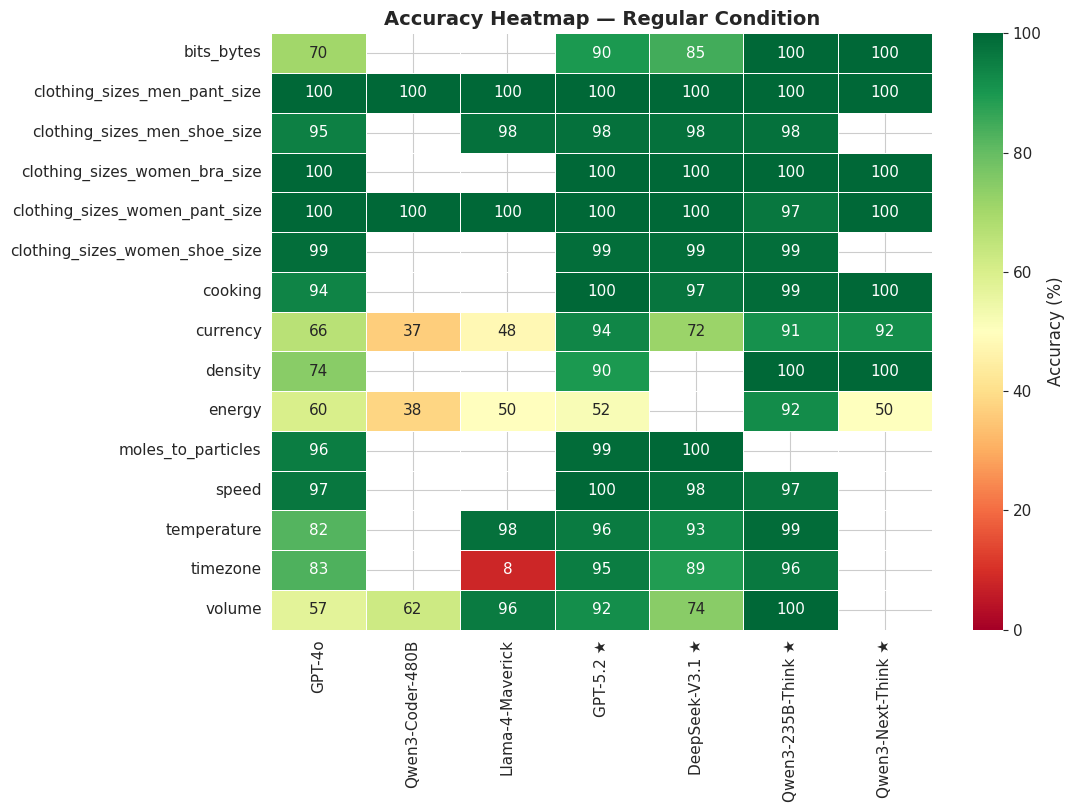

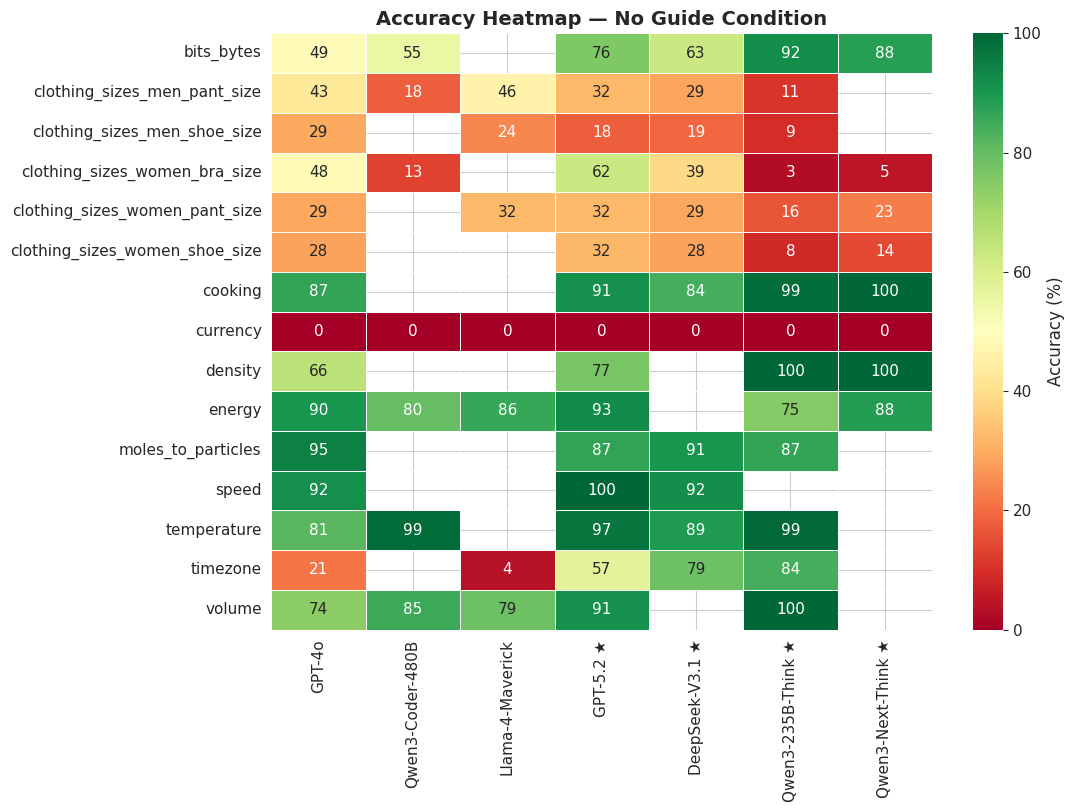

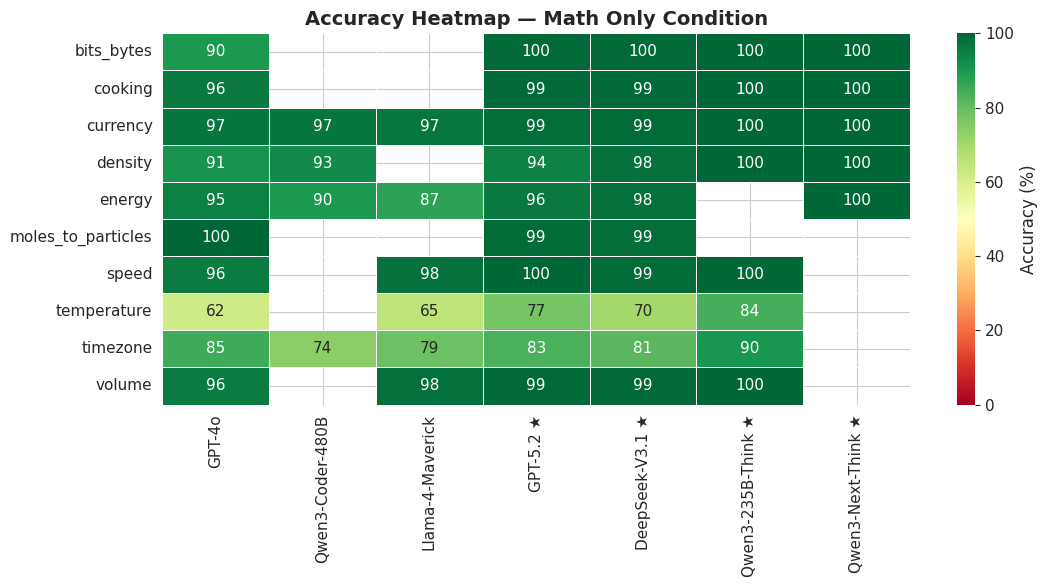

In [5]:
# One heatmap per condition — accuracy by domain × model
for cond in ['regular', 'no_guide', 'math_only']:
    sub = df_stats[df_stats['condition'] == cond]
    if sub.empty:
        continue
    pivot = sub.pivot_table(index='domain', columns='display_name', values='accuracy')
    # Reorder columns: non-reasoning first, then reasoning
    col_order = [MODEL_DISPLAY[m] for m in ALL_MODELS if MODEL_DISPLAY[m] in pivot.columns]
    pivot = pivot[col_order]

    fig, ax = plt.subplots(figsize=(max(10, len(col_order)*1.6), max(6, len(pivot)*0.55)))
    sns.heatmap(pivot, annot=True, fmt='.0f', cmap='RdYlGn', vmin=0, vmax=100,
                cbar_kws={'label': 'Accuracy (%)'}, linewidths=.5, ax=ax)
    ax.set_title(f'Accuracy Heatmap — {cond.replace("_"," ").title()} Condition', fontweight='bold')
    ax.set_ylabel(''); ax.set_xlabel('')
    plt.tight_layout()
    plt.show()

## Overall Accuracy by Model

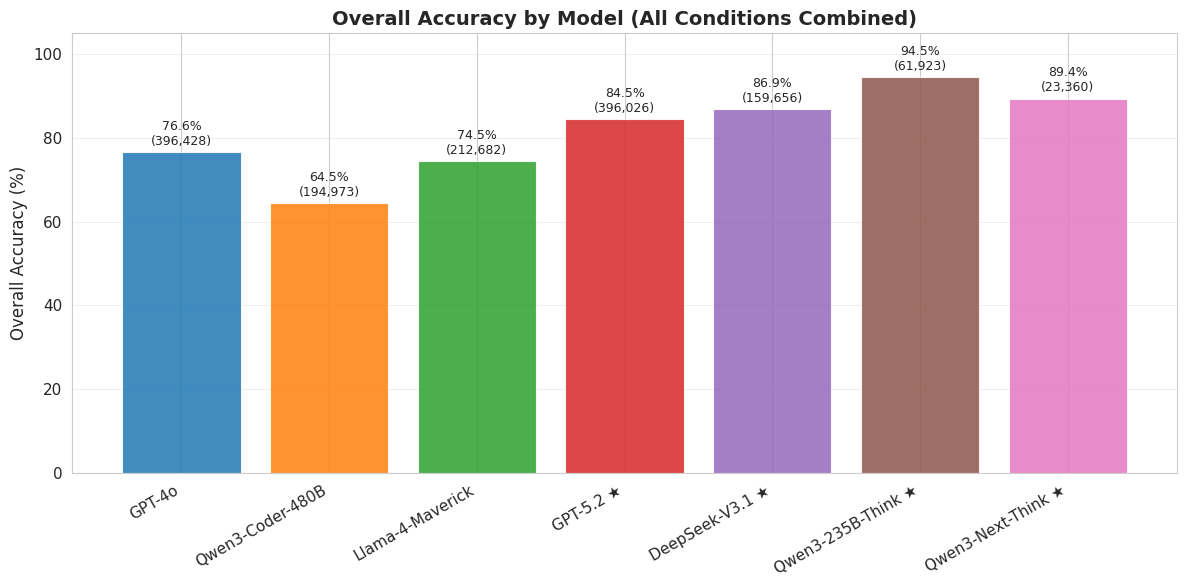

In [6]:
# Overall accuracy per model (aggregated across all conditions and domains)
model_overall = df_stats.groupby('model').apply(
    lambda g: pd.Series({
        'accuracy': g['correct'].sum() / g['valid'].sum() * 100 if g['valid'].sum() > 0 else 0,
        'total_rows': g['valid'].sum(),
    })
).reindex(ALL_MODELS)
model_overall['display'] = [MODEL_DISPLAY[m] for m in model_overall.index]
model_overall['color'] = [MODEL_COLORS[m] for m in model_overall.index]
model_overall = model_overall.dropna(subset=['accuracy'])

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(model_overall['display'], model_overall['accuracy'],
              color=model_overall['color'], alpha=0.85, edgecolor='white', linewidth=0.8)
ax.set_ylabel('Overall Accuracy (%)')
ax.set_title('Overall Accuracy by Model (All Conditions Combined)', fontweight='bold')
ax.set_ylim(0, 105)
ax.grid(axis='y', alpha=0.3)
# Add value labels
for bar, val, n in zip(bars, model_overall['accuracy'], model_overall['total_rows']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{val:.1f}%\n({int(n):,})', ha='center', va='bottom', fontsize=9)
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()

## Accuracy by Model × Condition

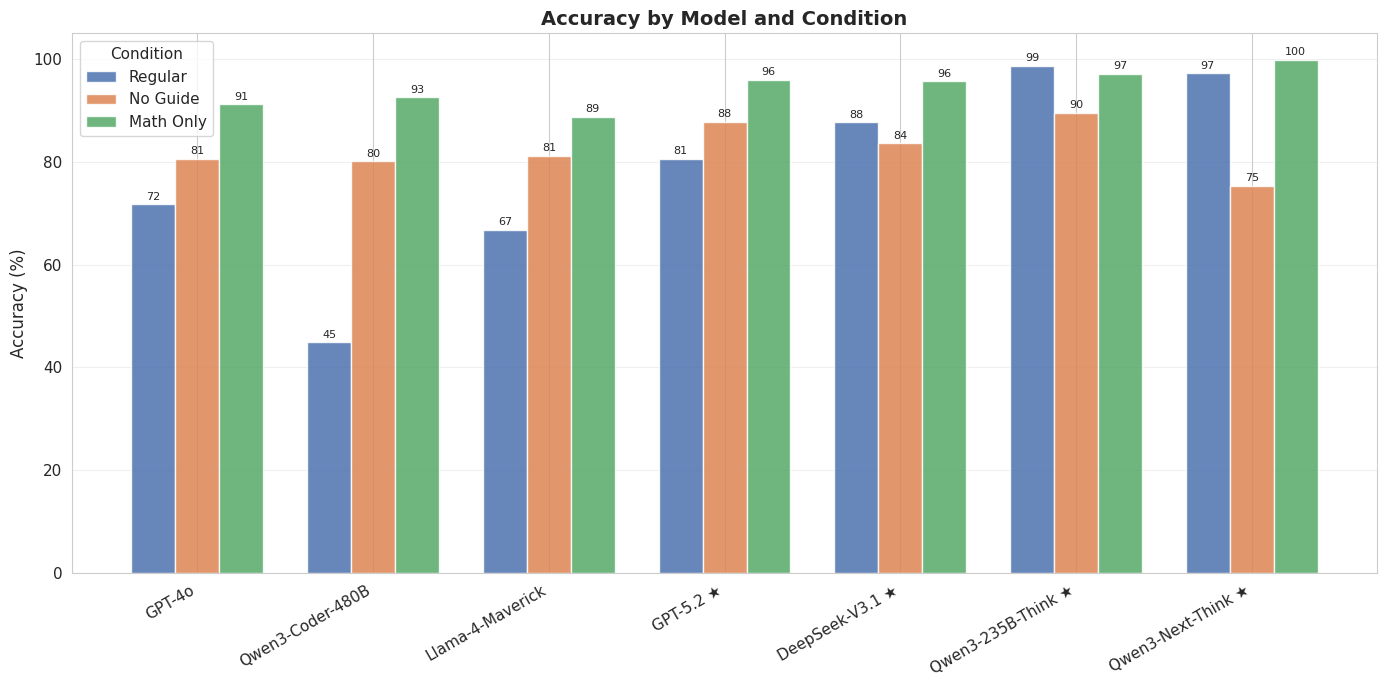

In [7]:
# Accuracy by model × condition (grouped bar)
cond_order = ['regular', 'no_guide', 'math_only']
cond_colors = {'regular': '#4c72b0', 'no_guide': '#dd8452', 'math_only': '#55a868'}
model_order = [m for m in ALL_MODELS if m in df_stats['model'].unique()]
display_order = [MODEL_DISPLAY[m] for m in model_order]

fig, ax = plt.subplots(figsize=(14, 7))
x = np.arange(len(model_order))
width = 0.25

for i, cond in enumerate(cond_order):
    sub = df_stats[df_stats['condition'] == cond]
    accs = []
    for m in model_order:
        g = sub[sub['model'] == m]
        acc = g['correct'].sum() / g['valid'].sum() * 100 if g['valid'].sum() > 0 else 0
        accs.append(acc)
    bars = ax.bar(x + i*width, accs, width, label=cond.replace('_',' ').title(),
                  color=cond_colors[cond], alpha=0.85)
    for bar, val in zip(bars, accs):
        if val > 0:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                    f'{val:.0f}', ha='center', va='bottom', fontsize=8)

ax.set_xticks(x + width)
ax.set_xticklabels(display_order, rotation=30, ha='right')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy by Model and Condition', fontweight='bold')
ax.set_ylim(0, 105)
ax.legend(title='Condition')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Reasoning vs Non-Reasoning Comparison

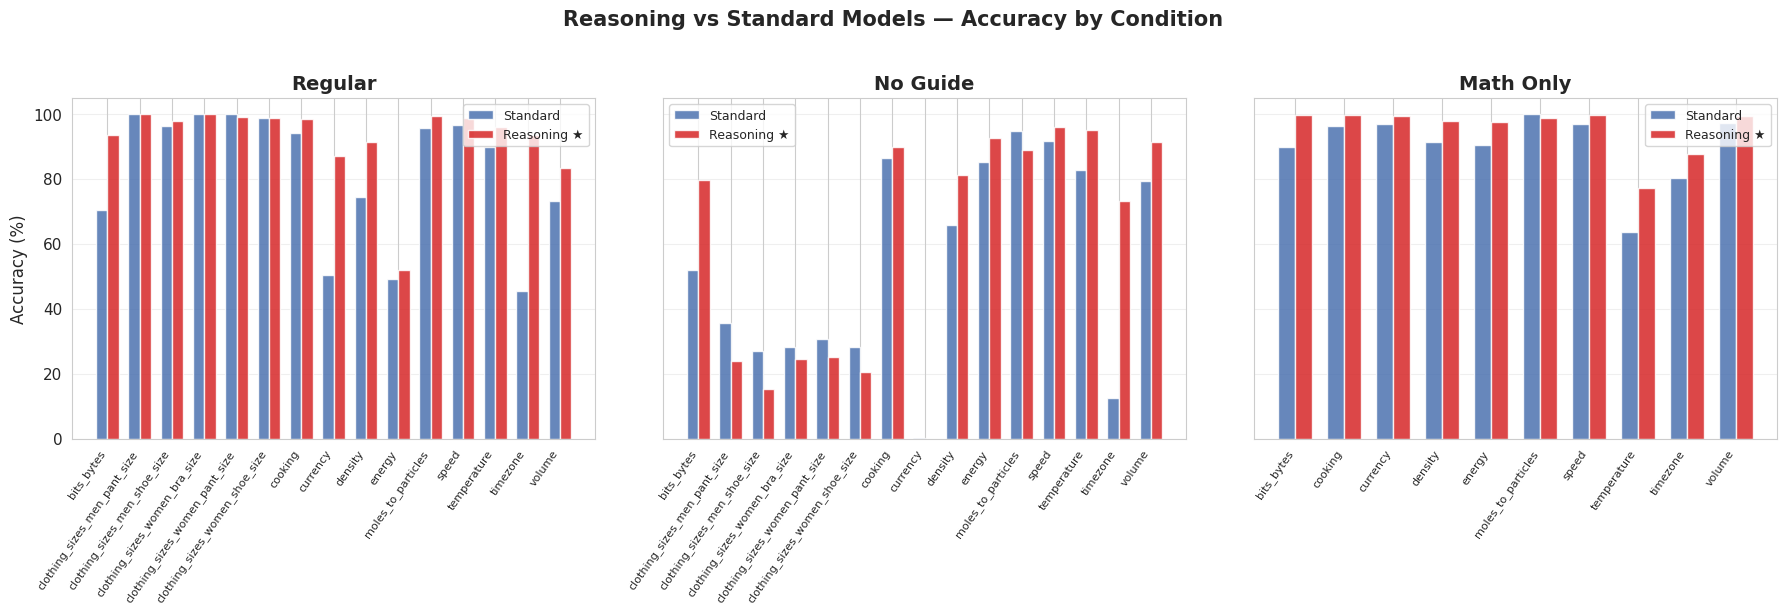

In [8]:
# Compare reasoning vs non-reasoning accuracy on domains where BOTH have data
# For each condition, find domains that have at least one reasoning + one non-reasoning model result
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for idx, cond in enumerate(['regular', 'no_guide', 'math_only']):
    ax = axes[idx]
    sub = df_stats[df_stats['condition'] == cond].copy()
    if sub.empty:
        ax.set_title(f'{cond.replace("_"," ").title()}\n(no data)')
        continue

    # Get domains with both types
    r_domains = set(sub[sub['is_reasoning']]['domain'].unique())
    nr_domains = set(sub[~sub['is_reasoning']]['domain'].unique())
    common_domains = sorted(r_domains & nr_domains)

    if not common_domains:
        ax.set_title(f'{cond.replace("_"," ").title()}\n(no overlapping domains)')
        continue

    sub = sub[sub['domain'].isin(common_domains)]

    # Aggregate by reasoning flag per domain
    agg = sub.groupby(['domain', 'is_reasoning']).apply(
        lambda g: g['correct'].sum() / g['valid'].sum() * 100 if g['valid'].sum() > 0 else 0
    ).unstack('is_reasoning').rename(columns={False: 'Standard', True: 'Reasoning'})

    x = np.arange(len(agg))
    w = 0.35
    ax.bar(x - w/2, agg['Standard'], w, label='Standard', color='#4c72b0', alpha=0.85)
    ax.bar(x + w/2, agg['Reasoning'], w, label='Reasoning ★', color='#d62728', alpha=0.85)
    ax.set_xticks(x)
    ax.set_xticklabels(agg.index, rotation=55, ha='right', fontsize=8)
    ax.set_title(cond.replace('_', ' ').title(), fontweight='bold')
    ax.set_ylim(0, 105)
    ax.grid(axis='y', alpha=0.3)
    if idx == 0:
        ax.set_ylabel('Accuracy (%)')
    ax.legend(fontsize=9)

plt.suptitle('Reasoning vs Standard Models — Accuracy by Condition', fontweight='bold', fontsize=15, y=1.02)
plt.tight_layout()
plt.show()

## Domain Difficulty

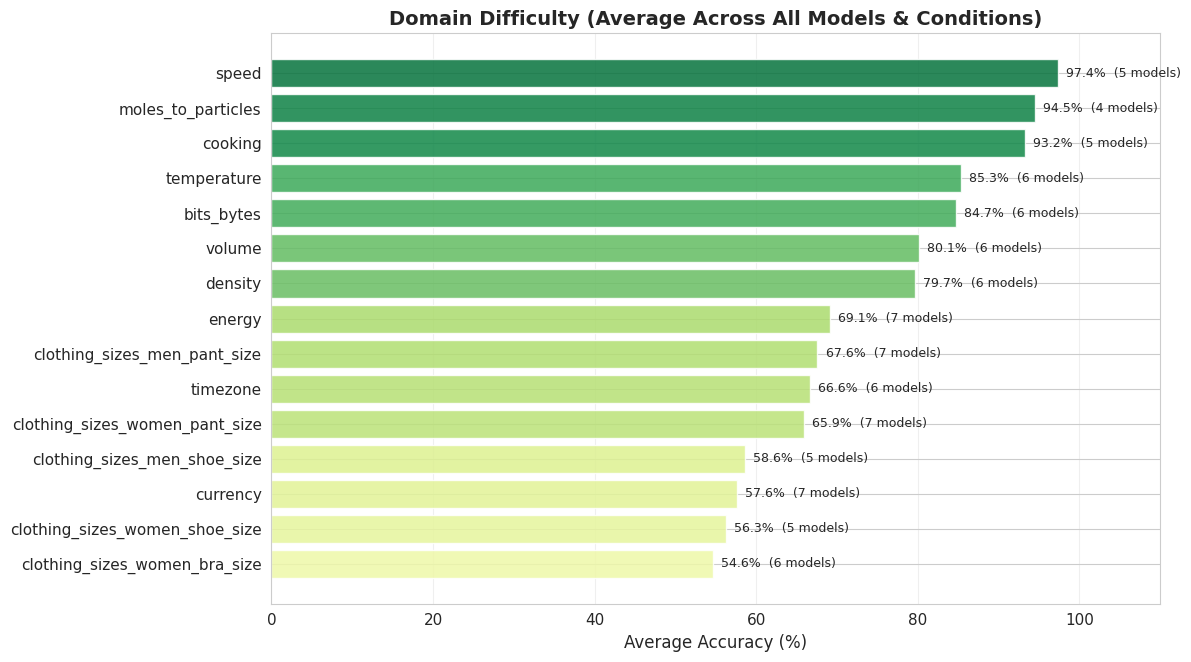

In [9]:
# Domain difficulty — averaged across all models and conditions with data
domain_avg = df_stats.groupby('domain').apply(
    lambda g: pd.Series({
        'accuracy': g['correct'].sum() / g['valid'].sum() * 100 if g['valid'].sum() > 0 else 0,
        'n_models': g['model'].nunique(),
    })
).sort_values('accuracy', ascending=True)

fig, ax = plt.subplots(figsize=(12, max(6, len(domain_avg)*0.45)))
colors = plt.cm.RdYlGn(domain_avg['accuracy'] / 100)
bars = ax.barh(domain_avg.index, domain_avg['accuracy'], color=colors, alpha=0.85, edgecolor='white')
ax.set_xlabel('Average Accuracy (%)')
ax.set_title('Domain Difficulty (Average Across All Models & Conditions)', fontweight='bold')
ax.set_xlim(0, 110)
ax.grid(axis='x', alpha=0.3)
for bar, (domain, row) in zip(bars, domain_avg.iterrows()):
    ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
            f'{row["accuracy"]:.1f}%  ({int(row["n_models"])} models)',
            va='center', fontsize=9)
plt.tight_layout()
plt.show()

## Impact of Conversion Guide (Regular vs No-Guide)

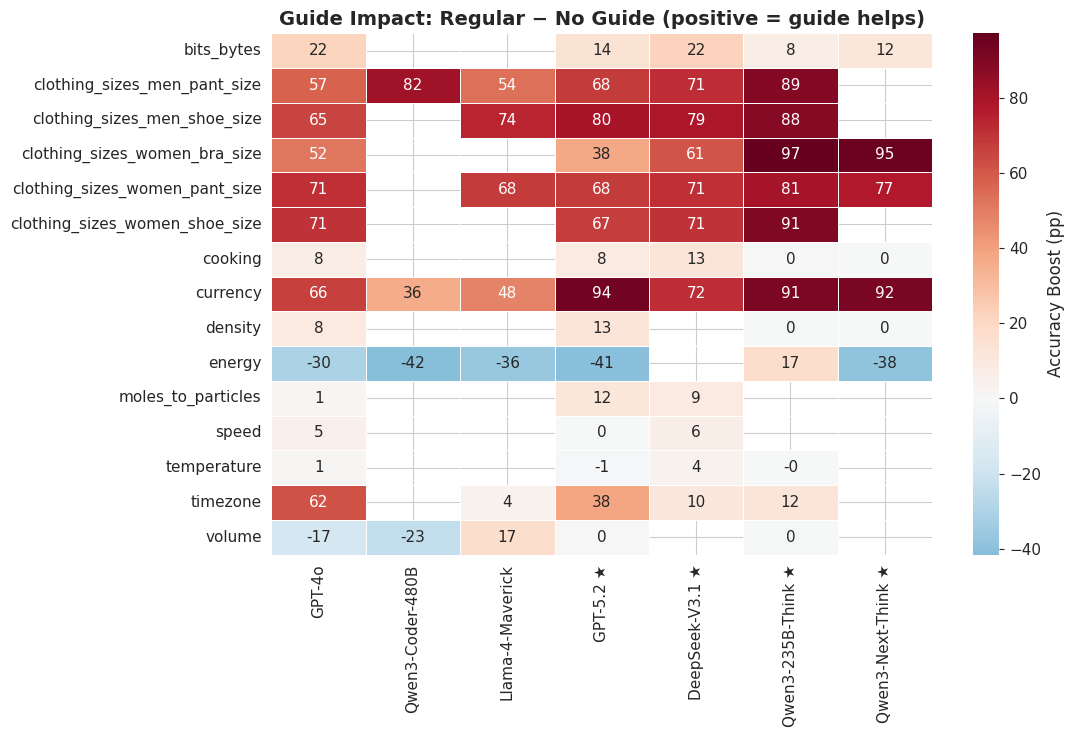


Average guide impact per model:
                    Mean Boost (pp)  Median Boost (pp)  Domains
GPT-4o                         29.4               21.5       15
Qwen3-Coder-480B               13.5                6.6        4
Llama-4-Maverick               32.6               48.0        7
GPT-5.2 ★                      30.5               13.9       15
DeepSeek-V3.1 ★                40.8               41.7       12
Qwen3-235B-Think ★             44.2               17.3       13
Qwen3-Next-Think ★             34.0               11.6        7


In [10]:
# Compare regular (with guide) vs no_guide for each model
stats_reg = df_stats[df_stats['condition'] == 'regular'][['model','domain','accuracy']].rename(columns={'accuracy':'acc_regular'})
stats_nog = df_stats[df_stats['condition'] == 'no_guide'][['model','domain','accuracy']].rename(columns={'accuracy':'acc_no_guide'})

guide_cmp = stats_reg.merge(stats_nog, on=['model','domain'])
guide_cmp['guide_boost'] = guide_cmp['acc_regular'] - guide_cmp['acc_no_guide']

if guide_cmp.empty:
    print("Not enough data to compare regular vs no-guide yet.")
else:
    # Pivot: domain × model showing guide boost
    pivot_boost = guide_cmp.pivot_table(index='domain', columns='model', values='guide_boost')
    col_order = [m for m in ALL_MODELS if m in pivot_boost.columns]
    pivot_boost = pivot_boost[col_order]
    pivot_boost.columns = [MODEL_DISPLAY[m] for m in col_order]

    fig, ax = plt.subplots(figsize=(max(10, len(col_order)*1.6), max(6, len(pivot_boost)*0.5)))
    sns.heatmap(pivot_boost, annot=True, fmt='.0f', cmap='RdBu_r', center=0,
                cbar_kws={'label': 'Accuracy Boost (pp)'}, linewidths=.5, ax=ax)
    ax.set_title('Guide Impact: Regular − No Guide (positive = guide helps)', fontweight='bold')
    ax.set_ylabel(''); ax.set_xlabel('')
    plt.tight_layout()
    plt.show()

    # Summary: average boost per model
    boost_summary = guide_cmp.groupby('model')['guide_boost'].agg(['mean','median','count']).reindex(ALL_MODELS).dropna()
    boost_summary.index = [MODEL_DISPLAY[m] for m in boost_summary.index]
    boost_summary.columns = ['Mean Boost (pp)', 'Median Boost (pp)', 'Domains']
    print("\nAverage guide impact per model:")
    print(boost_summary.round(1).to_string())

## Data Completeness & Coverage

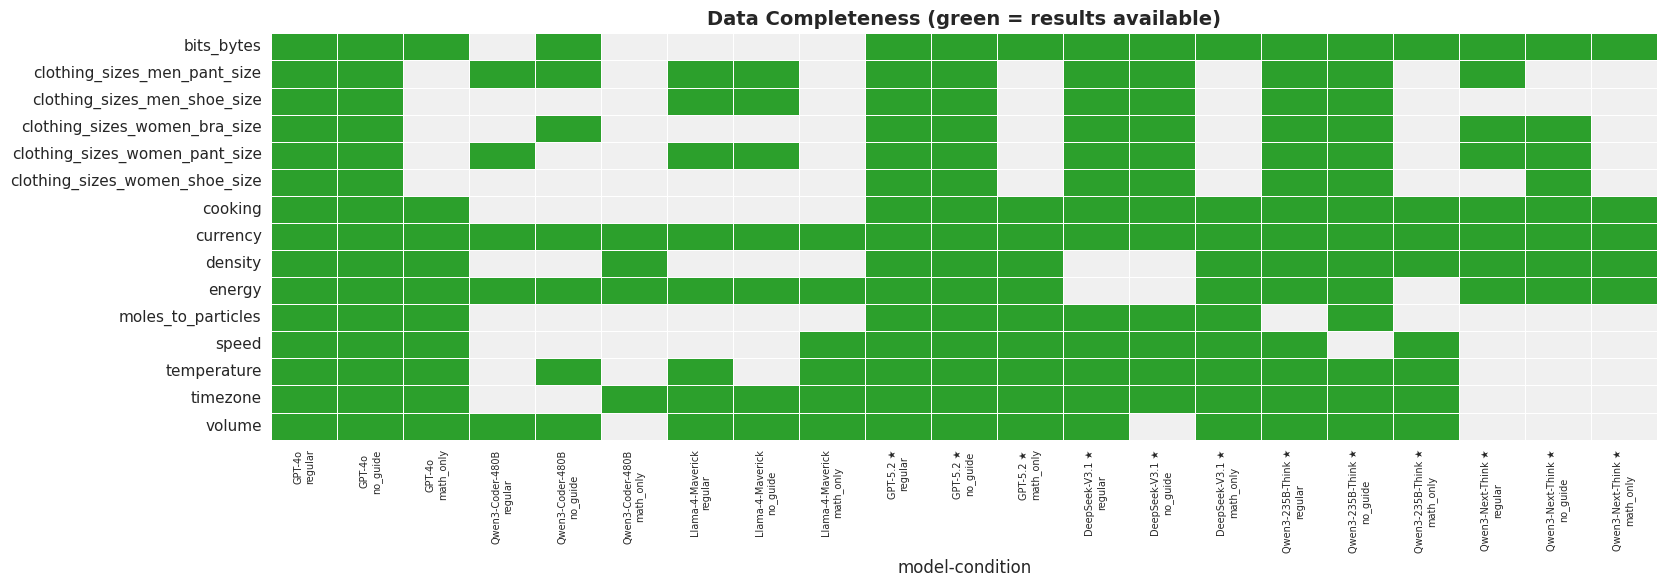


Coverage: 209/315 cells have data (66%)
(Some jobs may still be running — coverage will increase.)


In [11]:
# Show which model × condition × domain combos have data (binary heatmap)
all_domains = sorted(df_stats['domain'].unique())
completeness = []
for model in ALL_MODELS:
    for cond in ['regular', 'no_guide', 'math_only']:
        domains_done = set(df_stats[(df_stats['model']==model) & (df_stats['condition']==cond)]['domain'])
        for d in all_domains:
            completeness.append({
                'model': MODEL_DISPLAY.get(model, model),
                'condition': cond,
                'domain': d,
                'has_data': 1 if d in domains_done else 0
            })
df_comp = pd.DataFrame(completeness)

pivot_comp = df_comp.pivot_table(index='domain', columns=['model','condition'], values='has_data', fill_value=0)

# Flatten and reorder
flat_cols = []
for m in ALL_MODELS:
    dn = MODEL_DISPLAY.get(m, m)
    for c in ['regular','no_guide','math_only']:
        if (dn, c) in pivot_comp.columns:
            flat_cols.append((dn, c))
pivot_comp = pivot_comp[flat_cols]

fig, ax = plt.subplots(figsize=(max(14, len(flat_cols)*0.8), max(6, len(all_domains)*0.4)))
sns.heatmap(pivot_comp, cmap=['#f0f0f0','#2ca02c'], cbar=False, linewidths=0.5, ax=ax,
            xticklabels=[f'{m}\n{c}' for m, c in flat_cols])
ax.set_title('Data Completeness (green = results available)', fontweight='bold')
ax.set_ylabel('')
ax.tick_params(axis='x', labelsize=7, rotation=90)
plt.tight_layout()
plt.show()

n_possible = len(ALL_MODELS) * 3 * len(all_domains)
n_done = df_comp['has_data'].sum()
print(f"\nCoverage: {n_done}/{n_possible} cells have data ({n_done/n_possible*100:.0f}%)")
print("(Some jobs may still be running — coverage will increase.)")

## Accuracy by Conversion Category

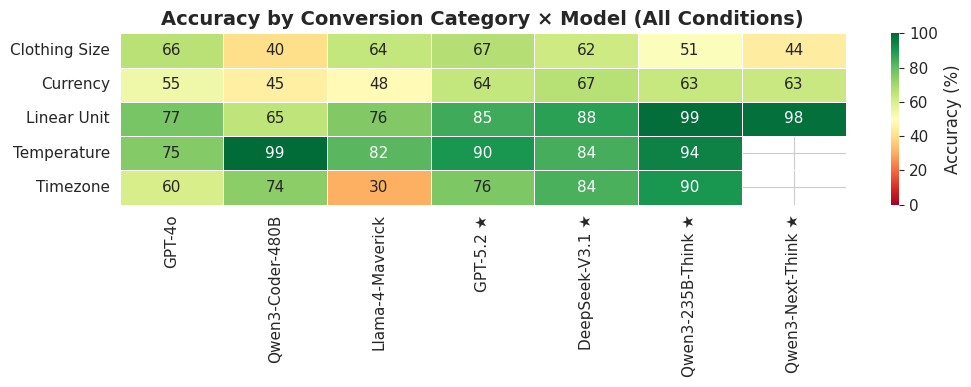

In [12]:
# Categorize domains and show accuracy by category
DOMAIN_CATEGORIES = {
    'Linear Unit': ['volume', 'speed', 'density', 'bits_bytes', 'energy', 'cooking', 'moles_to_particles'],
    'Currency': ['currency'],
    'Temperature': ['temperature'],
    'Timezone': ['timezone'],
    'Clothing Size': [d for d in df_stats['domain'].unique() if 'clothing' in d],
}

df_stats['category'] = df_stats['domain'].apply(
    lambda d: next((cat for cat, doms in DOMAIN_CATEGORIES.items() if d in doms), 'Other')
)

# Heatmap: category × model (averaged over conditions)
cat_acc = df_stats.groupby(['category', 'model']).apply(
    lambda g: g['correct'].sum() / g['valid'].sum() * 100 if g['valid'].sum() > 0 else np.nan
).unstack('model')

col_order = [m for m in ALL_MODELS if m in cat_acc.columns]
cat_acc = cat_acc[col_order]
cat_acc.columns = [MODEL_DISPLAY[m] for m in col_order]

fig, ax = plt.subplots(figsize=(max(10, len(col_order)*1.5), max(4, len(cat_acc)*0.8)))
sns.heatmap(cat_acc, annot=True, fmt='.0f', cmap='RdYlGn', vmin=0, vmax=100,
            cbar_kws={'label': 'Accuracy (%)'}, linewidths=.5, ax=ax)
ax.set_title('Accuracy by Conversion Category × Model (All Conditions)', fontweight='bold')
ax.set_ylabel(''); ax.set_xlabel('')
plt.tight_layout()
plt.show()

## Math-Only vs Regular: Does Removing Context Hurt?

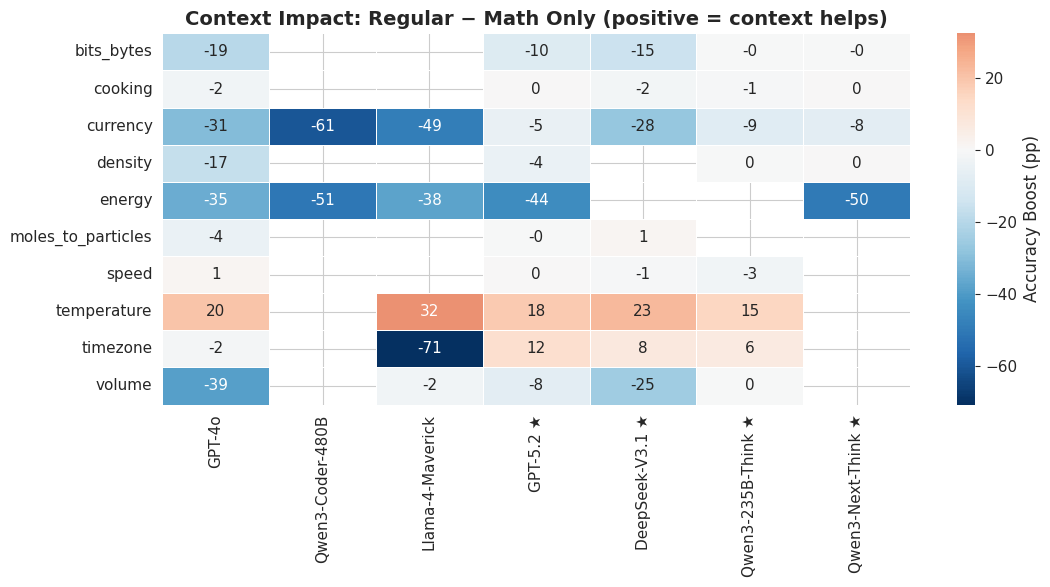


Average context impact per model (Regular − Math-Only):
                    Mean Boost (pp)  Median Boost (pp)  Domains
GPT-4o                        -12.8              -10.4       10
Qwen3-Coder-480B              -56.0              -56.0        2
Llama-4-Maverick              -25.4              -37.6        5
GPT-5.2 ★                      -4.1               -2.2       10
DeepSeek-V3.1 ★                -4.8               -1.4        8
Qwen3-235B-Think ★              1.1               -0.2        8
Qwen3-Next-Think ★            -11.5               -0.3        5


In [13]:
# Compare regular vs math_only
stats_reg2 = df_stats[df_stats['condition'] == 'regular'][['model','domain','accuracy']].rename(columns={'accuracy':'acc_regular'})
stats_mo = df_stats[df_stats['condition'] == 'math_only'][['model','domain','accuracy']].rename(columns={'accuracy':'acc_math_only'})

math_cmp = stats_reg2.merge(stats_mo, on=['model','domain'])
math_cmp['context_boost'] = math_cmp['acc_regular'] - math_cmp['acc_math_only']

if math_cmp.empty:
    print("Not enough overlapping data to compare regular vs math-only yet.")
else:
    pivot_math = math_cmp.pivot_table(index='domain', columns='model', values='context_boost')
    col_order = [m for m in ALL_MODELS if m in pivot_math.columns]
    pivot_math = pivot_math[col_order]
    pivot_math.columns = [MODEL_DISPLAY[m] for m in col_order]

    fig, ax = plt.subplots(figsize=(max(10, len(col_order)*1.6), max(6, len(pivot_math)*0.5)))
    sns.heatmap(pivot_math, annot=True, fmt='.0f', cmap='RdBu_r', center=0,
                cbar_kws={'label': 'Accuracy Boost (pp)'}, linewidths=.5, ax=ax)
    ax.set_title('Context Impact: Regular − Math Only (positive = context helps)', fontweight='bold')
    ax.set_ylabel(''); ax.set_xlabel('')
    plt.tight_layout()
    plt.show()

    ctx_summary = math_cmp.groupby('model')['context_boost'].agg(['mean','median','count']).reindex(ALL_MODELS).dropna()
    ctx_summary.index = [MODEL_DISPLAY[m] for m in ctx_summary.index]
    ctx_summary.columns = ['Mean Boost (pp)', 'Median Boost (pp)', 'Domains']
    print("\nAverage context impact per model (Regular − Math-Only):")
    print(ctx_summary.round(1).to_string())